<a href="https://colab.research.google.com/github/stratis-forge/radiomics-workflows/blob/main/demo_convolutional_texture_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
In this notebook we demonstrate how to apply the Laplacian of Gaussian (LoG), Gabor, and Laws' image filters to a sample lung CT scan using CERR. These filters are compatible with the Image Biomarker Standardization Initiative's ([IBSI-2](https://theibsi.github.io/ibsi2/)) guidelines.

### Requirements 
* GNU Octave with `statistics` & `image` packages
* [CERR](https://www.github.com/cerr/CERR.git)
* JSON configuration file for filter settings
* Python packages for visualization

### I/O
In this example, we use sample images in CERR's native planC format (imported from DICOM) to compute texture maps, output as Octave/numpy matrices.

### Results
This notebook provides static display of the original and filtered response maps.

### References
IBSI-2 reference [manual](https://www.overleaf.com/project/5da9e0b82f399f0001ad3970)

______________________________________________________________________________

### Configuring Filter Parameters

This demo uses sample configuration files distributed with STRATIS.

    `!git clone https://github.com/stratis-forge/segmentation-workflows.git`

See [documentation](https://github.com/cerr/CERR/wiki/Texture-calculation) on defining custom config files.

### Installing GNU Octave and CERR

* GNU Octave with statistics, io & image packages for Debian/Linux is distributed via MSKCC Box.
* CERR is downloaded from https://github.com/CERR/cerr
* Oct2py and Octave_kernel Python packages are required to run Octave scripts.

See installation [instructions](https://github.com/stratis-forge/installation-and-dependencies) for different operating systems.

Octave and CERR can be saved to Google Drive and mounted within the notebook to reduce the installation overhead.

In [ ]:
# Locations of Octave, CERR, and input data
octave_path = '/content/octave'

cerr_path = '/content/CERR'

# Sample data location
data_path = '/content/data/tcia_nsclc_cerr'  #Replace with path to CERR archives

# Sample filter configurations:

# 1. Laplacian of Gaussian (LoG) filter 
log_settings_path = '/content/sample_settings/sample_LoG_filter.json'  
# 2. Gabor filter 
gabor_settings_path = '/content/sample_settings/sample_gabor_filter.json'
# 3. Rotation invariant Laws' filter
laws_settings_path = '/content/sample_settings/sample_laws_rot_invariant_filter.json'

Uncomment (`Ctrl + /`) and evaluate the cell below to download GNU Octave and CERR

In [ ]:
# %%capture

# # Download Octave
# oct_build_box = 'https://mskcc.box.com/shared/static/ylfkha0p66oc8v5kh2z1qx9m13n0ijcx.gz'
# oct_save_path = '/content/octave_7.3.0.tar.gz'
# ! wget {oct_build_box} -O {oct_save_path}
# ! tar xf {oct_save_path}
# ! rm {oct_save_path}

# # Download CERR
# ! cd "$(dirname -- "$cerr_path")" && git clone --depth 1 --single-branch --branch octave_dev https://www.github.com/cerr/CERR.git

Install dependencies for GNU Octave and Oct2py bridge


In [ ]:
# %%capture
# # Download dependencies for Using Octave
# ! apt-get update
# ! cd /usr/lib/x86_64-linux-gnu/ && ln -s libhdf5_serial.so.103 libhdf5_serial.so.100 && ln -s libreadline.so.8 libreadline.so.7
# ! apt-get install libgraphicsmagick++-q16-12 libcholmod3 libcxsparse3 \
# libumfpack5 libspqr2 libqrupdate1 libfftw3-3 libgfortran4 gnuplot openjdk-8-jdk

# # Set path to Octave exectuable 
# import os, urllib.request, json
# os.environ['OCTAVE_EXECUTABLE'] = octave_path + '/bin/octave-cli'
# os.environ['PATH'] = octave_path + '/bin:' + os.environ['PATH']

# # Install oct2py bridge for Python-Octave communication
# ! pip3 install octave_kernel
# ! pip3 install oct2py==5.6.0

In [ ]:
# Enable Octave magic
%load_ext oct2py.ipython

## Add CERR to GNU Octave path and load required Octave packages

In [ ]:
%octave_push cerr_path data_path log_settings_path laws_settings_path gabor_settings_path

In [ ]:
%%capture
%%octave
# Load the required Octave packages
pkg load statistics
pkg load image
pkg load io

curr_path = pwd;
cd(cerr_path)
addToPath(cerr_path)
cd(curr_path)

## Compute texture maps

### Load test image 

In [ ]:
%%octave
dirS = dir(fullfile(data_path,'*.mat'));
pt1 = dirS(1).name;
sample_data = fullfile(data_path,pt1);

planC = loadPlanC(sample_data, tempdir);
planC = updatePlanFields(planC);
planC = quality_assure_planC(sample_data, planC);

CERR>>  Loading LUNG1-001.mat...

CERR>>  Loaded LUNG1-001.mat...

### Compute texture maps

In [ ]:
%%octave

structNum = 1; #GTV
scanNum = 1;

planC = generateTextureMapFromPlanC(planC,scanNum,structNum,log_settings_path);

CERR>>  Using zValues to compute voxel thicknesses.

ans = 1

In [ ]:
%%octave
planC = generateTextureMapFromPlanC(planC,scanNum,structNum,laws_settings_path);

CERR>>  Using zValues to compute voxel thicknesses.

ans = 1

In [ ]:
%%octave
planC = generateTextureMapFromPlanC(planC,scanNum,structNum,gabor_settings_path);

CERR>>  Using zValues to compute voxel thicknesses.

ans = 1

### Extract original and filtered images for display

In [ ]:
%%capture
%%octave
## For display:

#Get original scan array
indexS = planC{end};
scanNum = 1;
ctOffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
origScanArray = single(getScanArray(scanNum,planC)) - ctOffset;

#Crop around GTV
mask3M = getStrMask(structNum,planC);
[minr,maxr,minc,maxc,mins,maxs] = compute_boundingbox(mask3M); 
origScanArray = origScanArray(minr:maxr,minc:maxc,mins:maxs);

#Get texture maps
nFilters = 3;
scanNumV =  length(planC{indexS.scan})-nFilters+1:length(planC{indexS.scan});
texMapC = cell(1,length(scanNumV));

#Loop over available maps
for nTex = 1:length(scanNumV)    
    scanNum = scanNumV(nTex);
    ctOffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
    textureMap = single(getScanArray(scanNum,planC)) - ctOffset;
    texMapC{nTex} = textureMap;
end

## Visualize output

In [ ]:
%octave_pull origScanArray texMapC

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dx, dy = 1, 1

x = np.arange(0, 256, dx)
y = np.arange(0, 256, dy)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

### E.g. display center slice

Slice 10


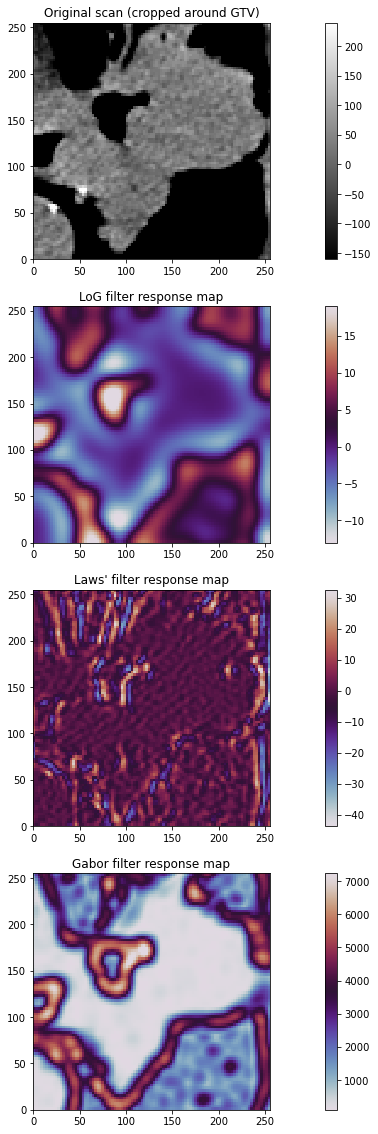

In [ ]:
# Plot center slice
scanSize = np.shape(origScanArray)
centerSlc = np.round(scanSize[2]/2).astype(int)
print('Slice '+ str(centerSlc))      

window_center = 40
window_width = 400
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(20,20))


windowed_img = window_image(origScanArray[:,:,centerSlc],
                                window_center,window_width)
plt1 = ax1.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
ax1.title.set_text('Original scan (cropped around GTV)')
cbar1 = fig.colorbar(plt1, ax=ax1, fraction=0.047)

window_center = 3
window_width = 33
textureMap = texMapC[0][0]
windowed_img = window_image(textureMap[:,:,centerSlc],
                                window_center,window_width)
plt2 = ax2.imshow(windowed_img,cmap=plt.cm.twilight, alpha=1,
                    interpolation='nearest', extent=extent) 
ax2.title.set_text("LoG filter response map")
cbar2 = fig.colorbar(plt2, ax=ax2, fraction=0.047)

window_center = 0
window_width = 88
textureMap = texMapC[0][1]
windowed_img = window_image(textureMap[:,:,centerSlc],
                                window_center,window_width)
plt3 = ax3.imshow(windowed_img,cmap=plt.cm.twilight, alpha=1,
                    interpolation='nearest', extent=extent) 
ax3.title.set_text("Laws' filter response map")
cbar3 = fig.colorbar(plt3, ax=ax3, fraction=0.047)

window_center = 3666
window_width = 7135
textureMap = texMapC[0][2]
windowed_img = window_image(textureMap[:,:,centerSlc],
                                window_center,window_width)
plt4 = ax4.imshow(windowed_img,cmap=plt.cm.twilight, alpha=1,
                    interpolation='nearest', extent=extent) 
ax4.title.set_text("Gabor filter response map")
cbar4 = fig.colorbar(plt4, ax=ax4, fraction=0.047)